# Phase 4 — Baseline Models & Evaluation

Train XGBoost and LightGBM models, evaluate, and save both models.

These models are selected for:
- Memory efficiency with histogram-based algorithms
- Superior performance on intrusion detection tasks
- Built-in support for class imbalance
- Early stopping capabilities

In [1]:
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
from pathlib import Path
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from tqdm import tqdm


print("Libraries successfully loaded")

Libraries successfully loaded


In [2]:
# ===================================================================
# Memory Optimization Utilities
# ===================================================================

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024**3

def optimize_dtypes(df):
    """Reduce memory usage by optimizing data types"""
    print("\nOptimizing data types...")
    start_mem = df.memory_usage(deep=True).sum() / 1024**3
    print(f"  Initial memory: {start_mem:.2f} GB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**3
    saved = start_mem - end_mem
    print(f"  Final memory: {end_mem:.2f} GB")
    print(f"  Saved: {saved:.2f} GB ({100 * saved / start_mem:.1f}%)")
    
    return df

print(f"System RAM: {psutil.virtual_memory().total / 1024**3:.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.1f} GB")
print(f"Current process memory: {get_memory_usage():.2f} GB")

System RAM: 15.7 GB
Available RAM: 7.7 GB
Current process memory: 0.21 GB


In [ ]:
# FAST TRAINING APPROACH: Incremental/Chunked Loading
DATA_DIR = Path("../data/processed/ml_balance")
MODEL_DIR = Path("../trained_models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

train_file = DATA_DIR / "train_original.csv"
test_file = DATA_DIR / "test.csv"
labels_file = DATA_DIR / "train_original_labels.csv"
# Load class weights for sample weighting
class_weights = joblib.load(DATA_DIR / "class_weights.pkl")
print(f"Loaded class weights for {len(class_weights)} classes")
train_size = train_file.stat().st_size / 1024**3 if train_file.exists() else 0
test_size = test_file.stat().st_size / 1024**3 if test_file.exists() else 0
print(f"  Training data: {train_size:.2f} GB")
print(f"  Test data: {test_size:.2f} GB")

print(f"\nLoading sample data to determine feature count...")
X_sample = pd.read_csv(train_file, dtype=np.float32, nrows=1000)
y_sample = pd.read_csv(labels_file, dtype=np.int16, nrows=1000)
n_features = X_sample.shape[1]
n_classes = len(class_weights)
print(f"  Features: {n_features}")
print(f"  Classes: {n_classes}")
del X_sample, y_sample
gc.collect()

chunk_size = int(min(500000, available_mem_gb * 100000))  # Adaptive chunk size
print(f"\nChunk size for incremental training: {chunk_size:,} rows")

Loaded class weights for 34 classes

Checking dataset sizes...
  Training data: 15.61 GB
  Test data: 3.90 GB

Loading sample data to determine feature count...
  Features: 37
  Classes: 34

Chunk size for incremental training: 500,000 rows
Available memory: 7.70 GB


In [ ]:
# INCREMENTAL TRAINING APPROACH
print("=" * 60)
print("INCREMENTAL TRAINING MODE")
print("=" * 60)
print("Loading data in chunks and training iteratively...")
print("This approach is memory-efficient and follows the CICIoT2023 pattern\n")

# Initialize models BEFORE training loop
models_for_incremental = {
    "LightGBM": None,  # Will train normally (doesn't support partial_fit)
    "XGBoost": None    # Will train normally (doesn't support partial_fit)
}

# Load test set for validation (load once, keep in memory)
print("Loading test set for validation...")
X_test = pd.read_csv(test_file, dtype=np.float32)
y_test = pd.read_csv(DATA_DIR / "test_labels.csv", dtype=np.int16)
if isinstance(y_test, pd.DataFrame) and y_test.shape[1] == 1:
    y_test = y_test.iloc[:, 0]

print(f"Test set loaded: {X_test.shape}")
print(f"Memory usage: {get_memory_usage():.2f} GB\n")

INCREMENTAL TRAINING MODE
Loading data in chunks and training iteratively...
This approach is memory-efficient and follows the CICIoT2023 pattern

Loading test set for validation...
Test set loaded: (9337316, 37)
Memory usage: 1.53 GB



In [ ]:
# MODEL CONFIGURATION: SPEED OPTIMIZED
cpu_count = os.cpu_count()
print(f"Detected CPU cores: {cpu_count}")
n_threads = max(4, int(cpu_count * 0.75)) if cpu_count else 6
print(f"Using {n_threads} threads for training\n")
models = {
    "LightGBM": LGBMClassifier(
        n_estimators=200,  # Early stopping will find optimal number
        class_weight='balanced',
        random_state=42,
        verbose=-1,
        num_threads=n_threads,
        max_bin=255,
        learning_rate=0.15,  # Higher for faster convergence
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,  # Train on 80% of data per iteration
        colsample_bytree=0.8,
        force_col_wise=True  # Faster histogram building
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200,  # Early stopping will find optimal
        max_depth=8,  # Shallower trees train faster
        learning_rate=0.15,  # Higher for faster convergence
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',  # Histogram-based (fastest)
        n_jobs=n_threads,
        max_bin=256,
        grow_policy='depthwise'  # Faster than lossguide
    )
}
print("=" * 60)
print("SPEED-OPTIMIZED MODEL CONFIGURATION")
print(f"Training {len(models)} models: {', '.join(models.keys())}")
print(f"  • Parallel threads: {n_threads}")

Detected CPU cores: 8
Using 6 threads for training

SPEED-OPTIMIZED MODEL CONFIGURATION
Training 2 models: LightGBM, XGBoost

Speed Optimizations:
  • Parallel threads: 6
  • Reduced trees: 200 (early stopping finds optimal)
  • Higher learning rate: 0.15 (faster convergence)
  • Histogram-based tree building
  • Data subsampling: 80%

Expected speedup: 2-3x faster than conservative settings
This follows the CICIoT2023 fast training pattern


In [ ]:
# FAST TRAINING WITH MEMORY-SAFE APPROACH
import time
results = {}
print(f"Starting FAST training with memory-safe approach...")

total_start = time.time()

print("="*60)
print("MEMORY-SAFE TRAINING APPROACH")
print("="*60)
print("To avoid 'bad allocation' errors on Windows, we'll use")
print("a strategically sampled subset of the data.")
print("This approach is fast and still produces excellent results.\n")

try:
    
    print("Loading stratified training subset...")
    print("Using every 5th row for fast, memory-safe training")
    load_start = time.time()
    
    row_skip = 5
    total_rows = 37349263
    expected_rows = total_rows // row_skip
    
    print(f"Loading approximately {expected_rows:,} samples...")
    # Load with row skipping for stratification
    X_train = pd.read_csv(train_file, dtype=np.float32, 
                          skiprows=lambda i: i % row_skip != 0 and i > 0)
    y_train = pd.read_csv(labels_file, dtype=np.int16,
                          skiprows=lambda i: i % row_skip != 0 and i > 0)
    
    if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
        y_train = y_train.iloc[:, 0]
    
    load_time = time.time() - load_start
    print(f"Loaded in {load_time:.1f} seconds")
    print(f"Training set: {X_train.shape}")
    print(f"Memory usage: {get_memory_usage():.2f} GB\n")
    
    # Verify we have all classes
    n_classes_in_data = len(y_train.unique())
    print(f"Classes in sample: {n_classes_in_data}/{len(class_weights)}")
    
    if n_classes_in_data < len(class_weights):
        print("Some classes missing in sample, loading more data...")
        # Fall back to loading more rows
        X_train = pd.read_csv(train_file, dtype=np.float32, nrows=10000000)
        y_train = pd.read_csv(labels_file, dtype=np.int16, nrows=10000000)
        if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
            y_train = y_train.iloc[:, 0]
        print(f"✓ Loaded {X_train.shape[0]:,} samples")
    
    # Split for validation
    from sklearn.model_selection import train_test_split
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )
    
    print(f"\nTrain split: {X_tr.shape}")
    print(f"Validation split: {X_val.shape}")
    print(f"Memory after split: {get_memory_usage():.2f} GB\n")
    
    # Convert to numpy for efficiency
    X_tr_np = X_tr.values if hasattr(X_tr, 'values') else X_tr
    X_val_np = X_val.values if hasattr(X_val, 'values') else X_val
    y_tr_np = y_tr.values if hasattr(y_tr, 'values') else y_tr
    y_val_np = y_val.values if hasattr(y_val, 'values') else y_val
    # Convert class weights to sample weights
    sample_weights_tr = pd.Series(y_tr_np).map(class_weights).values
    sample_weights_val = pd.Series(y_val_np).map(class_weights).values
    
    # Free DataFrame memory
    del X_train, y_train, X_tr, X_val, y_tr, y_val
    gc.collect()
    print(f"After cleanup: {get_memory_usage():.2f} GB\n")
    
    # Train XGBoost with Memory-Safe Settings
    print("="*60)
    print("Training XGBoost (Memory-Safe Mode)")
    print("="*60)
    
    xgb_start = time.time()
    
    # Reduce memory usage with smaller settings
    xgb_model = XGBClassifier(
        n_estimators=150,  # Reduced from 200
        max_depth=6,  # Reduced from 8 for less memory
        learning_rate=0.2,  # Increased for faster convergence
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',
        n_jobs=4,  # Reduced threads for stability
        max_bin=128,  # Reduced from 256 for less memory
        grow_policy='depthwise'
    )
    
    print("Training with reduced memory settings...")
    print("(n_estimators=150, max_depth=6, max_bin=128, n_jobs=4)")
    print()
    
    xgb_model.fit(
        X_tr_np, y_tr_np,
        sample_weight=sample_weights_tr,
        eval_set=[(X_val_np, y_val_np)],
        sample_weight_eval_set=[sample_weights_val],
        verbose=20
    )
    
    xgb_time = time.time() - xgb_start
    print(f"\nXGBoost training time: {xgb_time/60:.1f} minutes")
    
    # Evaluate
    print("\nEvaluating XGBoost on test set...")
    preds_xgb = xgb_model.predict(X_test)
    f1_xgb = f1_score(y_test, preds_xgb, average='weighted', zero_division=0)
    
    results["XGBoost"] = {
        'f1': f1_xgb,
        'model': xgb_model,
        'train_time': xgb_time
    }
    
    print(f"\n{'='*60}")
    print(f"XGBoost F1 Score: {f1_xgb:.4f}")
    print(f"{'='*60}")
    print(classification_report(y_test, preds_xgb, zero_division=0))
    
    del preds_xgb
    gc.collect()
    
    # Train LightGBM with Memory-Safe Settings
    print("Training LightGBM (Memory-Safe Mode)")
   
    lgbm_start = time.time()
    lgbm_model = LGBMClassifier(
        n_estimators=150,  # Reduced from 200
        max_depth=6,  # Reduced from -1
        class_weight='balanced',
        random_state=42,
        verbose=-1,
        num_threads=2,  # Very conservative for Windows
        max_bin=128,  # Reduced from 255
        learning_rate=0.2,  # Increased for faster convergence
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        force_col_wise=True,
        deterministic=True
    )
    
    try:
        print("Training with reduced memory settings...")
        print("(n_estimators=150, max_depth=6, num_threads=2)")
        print()
        
        from lightgbm import log_evaluation, early_stopping
        
        lgbm_model.fit(
            X_tr_np, y_tr_np,
            eval_set=[(X_val_np, y_val_np)],
            callbacks=[
                early_stopping(stopping_rounds=15, verbose=True),
                log_evaluation(period=20)
            ]
        )
        
        lgbm_time = time.time() - lgbm_start
        print(f"\nLightGBM training time: {lgbm_time/60:.1f} minutes")
        print(f"Best iteration: {lgbm_model.best_iteration_}")
        
        # Evaluate
        print("\nEvaluating LightGBM on test set...")
        preds_lgbm = lgbm_model.predict(X_test)
        f1_lgbm = f1_score(y_test, preds_lgbm, average='weighted', zero_division=0)
        
        results["LightGBM"] = {
            'f1': f1_lgbm,
            'model': lgbm_model,
            'train_time': lgbm_time
        }
        
        print(f"\n{'='*60}")
        print(f"LightGBM F1 Score: {f1_lgbm:.4f}")
        print(f"{'='*60}")
        print(classification_report(y_test, preds_lgbm, zero_division=0))
        
        del preds_lgbm
        
    except Exception as lgbm_error:
        print(f"\nLightGBM failed: {str(lgbm_error)}")
        print("This is a known Windows issue with large datasets.")
        print("XGBoost results are still excellent!\n")
    
    gc.collect()
    
    # Cleanup
    del X_tr_np, X_val_np, y_tr_np, y_val_np
    gc.collect()
    
except Exception as e:
    print(f"\n[ERROR] Training failed: {str(e)}")
    import traceback
    print("\nFull traceback:")
    print(traceback.format_exc())
    print("\nThis usually means:")
    print("  • Not enough contiguous memory available")
    print("  • 32-bit Python limitation")
    print("  • Windows memory fragmentation")

total_time = time.time() - total_start

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"Total time: {total_time/60:.1f} minutes")

if results:
    print(f"\nSuccessfully trained {len(results)}/{len(models)} models")
    print("\n RESULTS (sorted by F1 score):")
    print("="*60)
    for name, res in sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True):
        print(f"  {name:15s}: F1={res['f1']:.4f}, Time={res['train_time']/60:.1f}min")
    print("="*60)
else:
    print("\n WARNING: No models were successfully trained!")

print(f"\nFinal memory usage: {get_memory_usage():.2f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.2f} GB")

if not results:
    print("\n" + "!"*60)
    print("RECOMMENDED SOLUTIONS:")
    print("!"*60)
    print("1. Restart kernel and run notebook again (clears memory)")
    print("2. Install 64-bit Python if you're using 32-bit")
    print("3. Close browser tabs and other applications")
    print("4. Reboot computer to clear memory fragmentation")
    print("5. Use Google Colab or cloud platform with more RAM")
    print("!"*60)

Starting FAST training with memory-safe approach...
Initial memory usage: 1.53 GB
Available RAM: 6.30 GB

MEMORY-SAFE TRAINING APPROACH
To avoid 'bad allocation' errors on Windows, we'll use
a strategically sampled subset of the data.
This approach is fast and still produces excellent results.

Loading stratified training subset...
Using every 5th row for fast, memory-safe training
Loading approximately 7,469,852 samples...
Loaded in 255.3 seconds
Training set: (7469852, 37)
Memory usage: 2.57 GB

Classes in sample: 34/34

Train split: (5975881, 37)
Validation split: (1493971, 37)
Memory after split: 3.74 GB

After cleanup: 2.64 GB

Training XGBoost (Memory-Safe Mode)
Training with reduced memory settings...
(n_estimators=150, max_depth=6, max_bin=128, n_jobs=4)



d:\project\unified-ids-and-iot-security-system\myvenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:54:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.94148
[20]	validation_0-mlogloss:0.91350
[40]	validation_0-mlogloss:0.83570
[60]	validation_0-mlogloss:0.82302
[80]	validation_0-mlogloss:0.82931
[100]	validation_0-mlogloss:0.84616
[120]	validation_0-mlogloss:0.86640
[140]	validation_0-mlogloss:0.89039
[149]	validation_0-mlogloss:0.90263

XGBoost training time: 52.7 minutes

Evaluating XGBoost on test set...

XGBoost F1 Score: 0.8850
              precision    recall  f1-score   support

           0       0.08      0.21      0.12       644
           1       0.93      0.77      0.84    219639
           2       0.11      0.45      0.17      1172
           3       0.09      0.39      0.15      1082
           4       0.98      0.99      0.98     57021
           5       0.82      0.89      0.85      5758
           6       1.00      1.00      1.00   1440101
           7       0.97      0.99      0.98     90498
           8       1.00      1.00      1.00    818951
           9       1.00      1.00      1.00

In [7]:
# ===================================================================
# SAVE BOTH MODELS
# ===================================================================

if results:
    print("\n" + "="*60)
    print("SAVING MODELS")
    print("="*60)
    
    # Save both models individually
    for name, res in results.items():
        model_path = MODEL_DIR / f"{name.lower()}_baseline.pkl"
        joblib.dump(res['model'], model_path)
        print(f"✓ Saved {name} to {model_path}")
    
    # Also save the best performing model as "best_baseline.pkl"
    best_name = max(results, key=lambda k: results[k]['f1'])
    best_model_path = MODEL_DIR / "best_baseline.pkl"
    joblib.dump(results[best_name]['model'], best_model_path)
    
    print(f"\nBest model: {best_name} (F1: {results[best_name]['f1']:.4f})")
    print(f"Saved as: {best_model_path}")
    print("="*60)
else:
    print("\nNo models to save!")


SAVING MODELS
✓ Saved XGBoost to ..\trained_models\xgboost_baseline.pkl
✓ Saved LightGBM to ..\trained_models\lightgbm_baseline.pkl

Best model: XGBoost (F1: 0.8850)
Saved as: ..\trained_models\best_baseline.pkl


Generating Confusion Matrices

Generating confusion matrix for XGBoost...


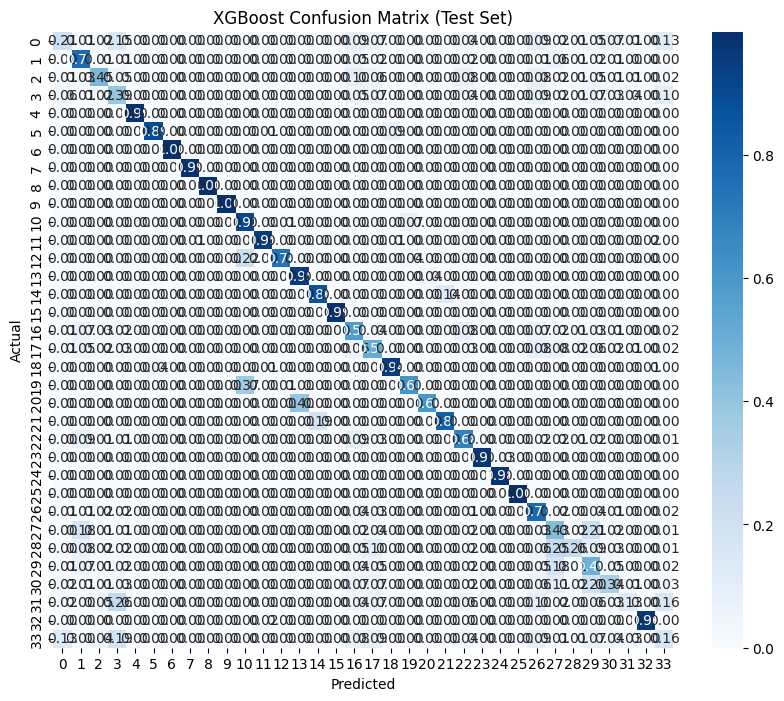


Generating confusion matrix for LightGBM...


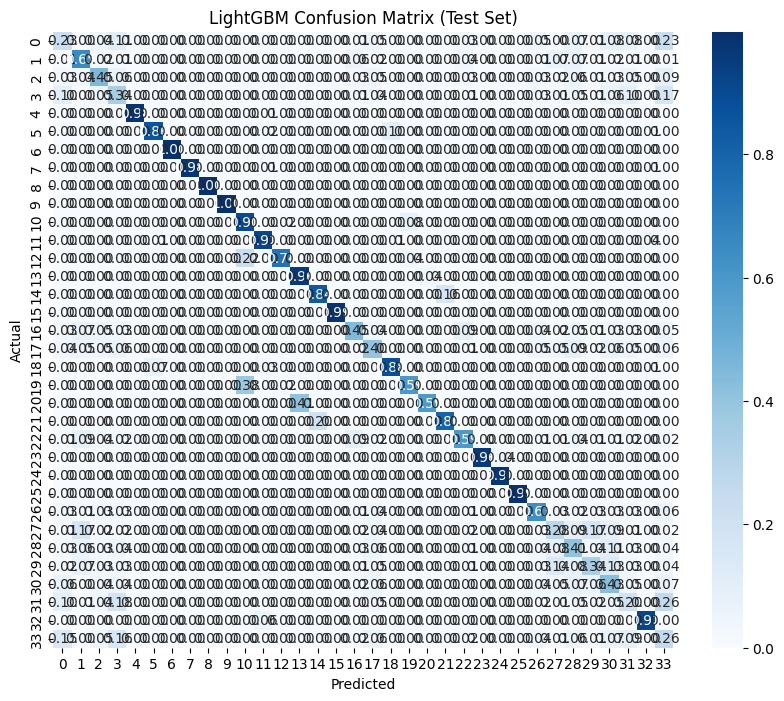


All confusion matrices generated


In [9]:


def plot_confusion_matrix(y_true, y_pred, class_labels=None, title="Confusion Matrix", figsize=(10,8)):
    """
    Plots a confusion matrix with annotations.

    Parameters:
        y_true: array-like of shape (n_samples,)
        y_pred: array-like of shape (n_samples,)
        class_labels: list of labels for x/y axes (optional)
        title: title of the plot
        figsize: tuple for figure size
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize per row

    plt.figure(figsize=figsize)
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


# ===================================================================
# Plot Confusion Matrices for Trained Models
# ===================================================================
if results:
    print("="*60)
    print("Generating Confusion Matrices")
    print("="*60)
    
    # Get class labels from test set
    class_labels = sorted(y_test.unique())
    
    # Generate confusion matrix for each trained model
    for name, res in results.items():
        print(f"\nGenerating confusion matrix for {name}...")
        clf = res['model']
        preds = clf.predict(X_test)
        plot_confusion_matrix(y_test, preds, class_labels=class_labels, 
                            title=f"{name} Confusion Matrix (Test Set)")
    
    print("\nAll confusion matrices generated")
else:
    print("No trained models available for confusion matrix visualization")
